In [1]:
## Import dependencies.
import os
import itertools
import scipy.io
import scipy.stats as stt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mou_model import MOU
%matplotlib inline

## Introduce constants.
_RES_DIR = 'model_parameter/'
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0

## Create a local folder to store results.
if not os.path.exists(_RES_DIR):
    print('created directory:', _RES_DIR)
    os.makedirs(_RES_DIR)

In [2]:
## Read in data and structure it.
fMRI_data_and_labels = scipy.io.loadmat('BOLD_data_and_SC_matrix/DATA_TASK_3DMOV_HP_CSF_WD.mat')
regionalized_preprocessed_fMRI_data = fMRI_data_and_labels['TASKEC'][0][0]
roi_labels = fMRI_data_and_labels['ROIlbls'][0]
rest_run_data = regionalized_preprocessed_fMRI_data['Rest']
# Display the ROI labels
print('R'+'\u0332'+'egions O'+'\u0332'+'f I'+'\u0332'+'nterest (ROIs): \n')
for i,elem in enumerate(np.concatenate(roi_labels)): 
    print(f'{i:2d} : {elem}')
# The fMRI data properties.
n_subjects = rest_run_data.shape[2]
n_runs = len(fMRI_data_and_labels['TASKEC'][0][0])
n_rois = rest_run_data.shape[1]
n_ts_samples = rest_run_data.shape[0]
# Restructure data.
filtered_ts_emp = np.zeros([n_subjects, n_runs, n_rois, n_ts_samples])
run = list(regionalized_preprocessed_fMRI_data.dtype.fields.keys())
for k in range(len(run)):
    filtered_ts_emp[:, k, :, :] = np.transpose(
        regionalized_preprocessed_fMRI_data[run[k]], (2, 1, 0))

R̲egions O̲f I̲nterest (ROIs): 

 0 : lh_bankssts
 1 : lh_caudalanteriorcingulate
 2 : lh_caudalmiddlefrontal
 3 : lh_cuneus
 4 : lh_entorhinal
 5 : lh_fusiform
 6 : lh_inferiorparietal
 7 : lh_inferiortemporal
 8 : lh_isthmuscingulate
 9 : lh_lateraloccipital
10 : lh_lateralorbitofrontal
11 : lh_lingual
12 : lh_medialorbitofrontal
13 : lh_middletemporal
14 : lh_parahippocampal
15 : lh_paracentral
16 : lh_parsopercularis
17 : lh_parsorbitalis
18 : lh_parstriangularis
19 : lh_pericalcarine
20 : lh_postcentral
21 : lh_posteriorcingulate
22 : lh_precentral
23 : lh_precuneus
24 : lh_rostralanteriorcingulate
25 : lh_rostralmiddlefrontal
26 : lh_superiorfrontal
27 : lh_superiorparietal
28 : lh_superiortemporal
29 : lh_supramarginal
30 : lh_frontalpole
31 : lh_temporalpole
32 : lh_transversetemporal
33 : lh_insula
34 : rh_bankssts
35 : rh_caudalanteriorcingulate
36 : rh_caudalmiddlefrontal
37 : rh_cuneus
38 : rh_entorhinal
39 : rh_fusiform
40 : rh_inferiorparietal
41 : rh_inferiortemporal
42 

## 3) Functional connectivity (FC)
<a id='FC'></a>

For test puposes the calculation of the FC has been transferred into a function. The plots for FC depicting $Q^0$ and $Q^1$ are based on a calculation with just one time shift, so that the covariances are calculated with time series of length T-1, where T ist the number of elements in the original time series.

The autocovariances, however, are calculated for time shifts of 0 TR, 1 TR, 2 TR, 3 TR (time resolution). So, FC and autocovariances have to be calculated separately, which is why the function has been introduced.

Due to rescaling (rescale factor =  3.2440038842406533 ) most of the FC values should be between 0 and 1
Mean FC0 value: 0.1389148775484873
Max FC0 value: 1.8634718952876235
Mean BOLD variance (diagonal of each FC0 matrix): 0.42666585368839943


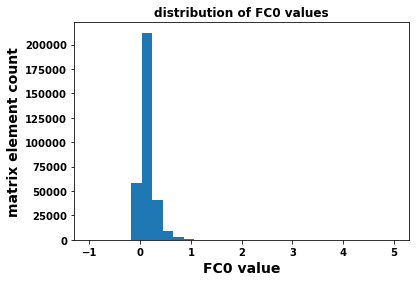

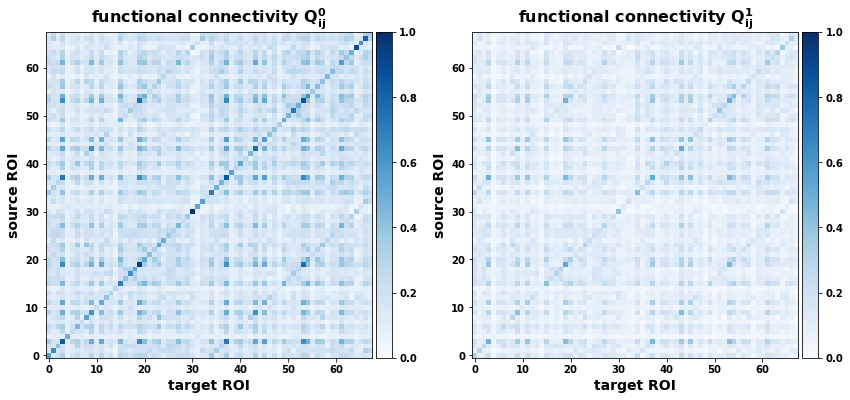

In [11]:
## Calculate functional connectivity (BOLD covariances) [Q0 and Q1].
time_shift = np.arange(2, dtype=float)
n_shifts = len(time_shift)

def calculate_FC(filtered_ts_emp, n_shifts):
    n_subjects, n_runs, n_rois, n_ts_samples = filtered_ts_emp.shape
    FC_emp = np.zeros([n_subjects, n_runs, n_shifts, n_rois, n_rois])
    n_ts_span = n_ts_samples - n_shifts + 1
    for i_subject in range(n_subjects):
        for i_run in range(n_runs):
            # Center the time series (around zero).
            filtered_ts_emp[i_subject, i_run, :, :] -=  \
                    np.outer(filtered_ts_emp[i_subject, i_run, :, :].
                             mean(axis=1), np.ones([n_ts_samples]))
            # Calculate covariances with various time shifts.
            for i_shift in range(n_shifts):
                FC_emp[i_subject, i_run, i_shift, :, :] = \
                    np.tensordot(filtered_ts_emp[i_subject, i_run, :,
                                                 0:n_ts_span],
                                 filtered_ts_emp[i_subject, i_run, :,
                                                 i_shift:n_ts_span + i_shift],
                                 axes=(1, 1)) / float(n_ts_span)
    return FC_emp

FC_emp = calculate_FC(filtered_ts_emp, n_shifts)
# # Scale FC to the range [0, 1].
# min_max_scaler = MinMaxScaler()
# FC0_rest_subj_avg = FC_emp[:, _I_REST_RUN,
#                           _I_NO_TIMESHIFT, :, :].mean(axis=_SUBJECT_AXIS)
# FC0_rest_subj_avg_rescaled = min_max_scaler.fit_transform(
#     FC0_rest_subj_avg.reshape(-1, 1)).reshape(n_rois, n_rois)
# FC_scaler = np.vectorize(lambda matrix_2d: min_max_scaler.transform(
#     matrix_2d.reshape(-1, 1)).reshape(
#     matrix_2d.shape), signature='(m,n)->(m,n)')
# FC_emp = FC_scaler(FC_emp[:, :, :, :, :].mean(axis=_SUBJECT_AXIS))
# print('After min-max-scaling the FC, the maximum value is: ', 
#       np.max(FC_emp[_I_REST_RUN, _I_NO_TIMESHIFT, :, :]), '\n')
# print('After min-max-scaling the FC, the minimum value is: ', 
#       np.min(FC_emp[_I_REST_RUN, _I_NO_TIMESHIFT, :, :]), '\n')

# Rescale as in aforementioned notebook (values not exclusively in [0, 1]):
rescale_FC_factor = (0.5 / FC_emp[:, _I_REST_RUN, _I_NO_TIMESHIFT, :,
                                  :].diagonal(axis1=1, axis2=2).mean())
FC_emp *= rescale_FC_factor
# filtered_ts_emp /= np.sqrt(rescale_FC_factor)

print('Due to rescaling (rescale factor = ', rescale_FC_factor,
      ') most of the FC values should be between 0 and 1')
# print('Due to the application of the min-max-scaler most of the FC values \
# should be between 0 and 1')
print('Mean FC0 value:', FC_emp[:, :, _I_NO_TIMESHIFT, :, :].mean())
print('Max FC0 value:', FC_emp[:, :, _I_NO_TIMESHIFT, :, :].max())
# print('Min FC0 value:', FC0_rest_subj_avg_rescaled.min())
# print('Max FC0 value:', FC0_rest_subj_avg_rescaled.max())
print('Mean BOLD variance (diagonal of each FC0 matrix):',
      FC_emp[:, :, _I_NO_TIMESHIFT, :, :].diagonal(axis1=2, axis2=3).mean())
# Show distibution of FC0 values.
plt.figure()
plt.hist(FC_emp[:, :, _I_NO_TIMESHIFT, :, :].flatten(),
         bins=np.linspace(-1, 5, 30))
plt.xlabel('FC0 value', fontsize=14)
plt.ylabel('matrix element count', fontsize=14)
plt.title('distribution of FC0 values')
# Show FC0 averaged over subjects for the rest run.
plt.figure(figsize=(14, 6))
plt.subplot(121)
FC_avg_over_subj = FC_emp[:, _I_REST_RUN,
                          _I_NO_TIMESHIFT, :, :].mean(axis=_SUBJECT_AXIS)
ax = plt.gca()
im = ax.imshow(FC_avg_over_subj, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)
# Show FC1 averaged over subjects for the rest run.
plt.subplot(122)
FC_avg_over_subj = FC_emp[:, _I_REST_RUN,
                          _I_ONE_TIMESHIFT, :, :].mean(axis=_SUBJECT_AXIS)
ax = plt.gca()
im = ax.imshow(FC_avg_over_subj, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
plt.show()

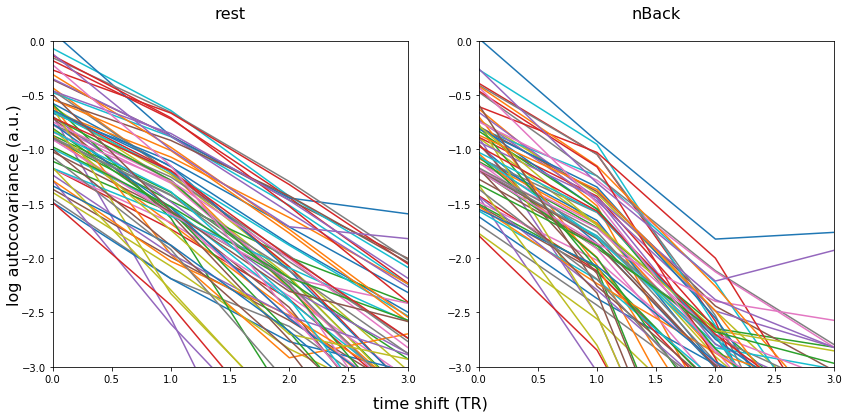

In [4]:
# Calculate the autocovariance. 
ac = FC_emp.diagonal(axis1=3, axis2=4)
# Show the autocovariance for the rest run.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.text(0.5, 0.03, 'time shift (TR)', ha='center', fontsize=16)
fig.text(0.08, 0.5, 'log autocovariance (a.u.)', va='center', 
         rotation='vertical', fontsize=16)
plt.subplot(121)
ac_avg_over_subj = np.log(np.maximum(ac[:, _I_REST_RUN, :, :].
                                     mean(axis=_SUBJECT_AXIS), np.exp(-5)))
plt.plot(range(n_shifts), ac_avg_over_subj)
plt.title('rest', fontsize=16, y=1.05)
plt.ylim((-3, 0))
plt.xlim((0, 3))
# Show the autocovariance for the nBack run.
plt.subplot(122)
ac_avg_over_subj = np.log(np.maximum(ac[:, _I_NBACK_RUN, :, :].
                                     mean(axis=_SUBJECT_AXIS), np.exp(-5)))
plt.plot(range(n_shifts), ac_avg_over_subj)
plt.title('nBack', fontsize=16, y=1.05)
plt.ylim((-3, 0))
plt.xlim((0, 3))
plt.show()

### Structural connectivity (SC)
The SC-matrix can be found at http://dutchconnectomelab.nl/ under the title 'Group-averaged binary connectivity matrix based on 50 healthy subjects. Data as used in the paper "Edge-centric perspective on the human connectome: link communities in the brain", De Reus et al. 2014, Philosophical Transactions of the Royal Society B. Oct 5;369(1653).' in the download section. Although this matrix is not the one used in the paper, it looks like the best alternative, for the paper does not provide a reference to the original matrix.

Typically, structural connectivity indicates 'the probability or the density of white-matter projections between pairs of ROIs in the parcellation. The algorithm that fits the model to the functional data (BOLD signals) only uses the information about whether there is a connection or not between two ROIs, to decide whether the corresponding weight is optimized.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) So, the downloaded binary matrix is completely sufficient for the purpose of reproducing the results from the abovementioned [Senden et al. (2017)](#references) paper.

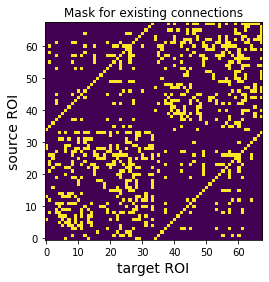

In [5]:
## Include structural connectivity.
# Load the binary structural connectivity matrix.
mask_EC = np.array(scipy.io.loadmat('BOLD_data_and_SC_matrix/BINARY_EC_MASK.mat')
                   ['grouped_umcu50_60percent'], dtype=bool)
# Enforce hermispheric connections.
for i in range(int(n_rois/2)):
    mask_EC[i, int(n_rois/2)+i] = True
    mask_EC[int(n_rois/2)+i, i] = True
# Visualise the binary structural connectivity mask.
plt.figure()
plt.imshow(mask_EC, origin='lower')
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('Mask for existing connections', fontsize=12)
plt.show()

### MOU-EC estimation
'The optimization procedure tunes the parameters of the MOU model, namely the directional connectivity ($C$, referred to as MOU-EC) and the input covariance ($\Sigma$). It is a gradient descent that aims to minimize the matrix distance between the model and empirical covariances (referred to as spatiotemporal FC). In practice, it is encapsulated in the *fit* method of the *MOU* class. For a tutorial of the use of the MOU class for simulation and estimation, check the [*MOU_Simulation_Estimation* notebook](#references).

The optimization algorithm works with learning rates for the connectivity and the input covariance ($\epsilon_C$ and $\epsilon_\Sigma$). If they are too fast, the fitting procedure may end up being stuck in a worse local minimum than what is achievable with smaller learning rates.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) In the paper (ct. [Senden et al. (2017)](#references)) $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ were chosen. For quicker but less finely graduated otimization try $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ with `mou_model.fit(filtered_ts_emp[i_sub,i_run,:,:].T, mask_C=mask_EC, mask_Sigma=mask_Sigma, epsilon_C=0.001, epsilon_Sigma=0.1)`.

All parameters/restrictions not explicitly passed to the fit@MOU method, have the correct defaults in fit_LO@MOU.

Depending on the value of $\epsilon_C$ the following cell might take about 30 minutes ($\epsilon_C = 0.0001) and more to run through.

In [6]:
## Calculate EC-matrix.
# Construct diagonal mask for input noise matrix
# (here, no input cross-correlation).
mask_Sigma = np.eye(n_rois, dtype=bool)

# Run the model optimization.
# Initialize the source arrays.
# Jacobian (off-diagonal elements = EC)
J_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])
# Local variance (input covariance matrix, chosen to be diagonal)
Sigma_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])
# Model error
dist_mod = np.zeros([n_subjects, n_runs])
# Approximation of variance about the fitted data (FC covariance matrices)
R2_mod = np.zeros([n_subjects, n_runs])
# Between-region EC matrix
C_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])

mou_model = MOU()

for i_subject in range(n_subjects):
    for i_run in range(n_runs):
        # Run the estimation of model parameters, for all sessions.
        mou_model.fit(filtered_ts_emp[i_subject, i_run, :, :].T,
                      mask_Sigma=mask_Sigma, mask_C=mask_EC)
        # Organize the optimization results into arrays.
        # Extract Jacobian of the model.
        J_mod[i_subject, i_run, :, :] = mou_model.J
        # Extract noise (auto-)covariance matrix.
        Sigma_mod[i_subject, i_run, :, :] = mou_model.Sigma
        # Extract the matrix distance between the empirical objective
        # covariances and their model counterparts
        # (normalized for each objective matrix).
        dist_mod[i_subject, i_run] = mou_model.d_fit['distance']
        # The squared Pearson correlation is taken as an approximation
        # of the variance.
        R2_mod[i_subject, i_run] = mou_model.d_fit['correlation']**2
        # The between-region EC matrix of the model
        C_mod[i_subject, i_run, :, :] = mou_model.get_C()

        print('sub / run:', i_subject, i_run, ';\t model error, R2:',
              dist_mod[i_subject, i_run], R2_mod[i_subject, i_run])
        # Store the results in files.
np.save(_RES_DIR + 'FC_emp.npy',
        FC_emp)  # Empirical spatiotemporal FC
np.save(_RES_DIR + 'mask_EC.npy',
        mask_EC)  # Mask of optimized connections
np.save(_RES_DIR + 'mask_Sigma.npy',
        mask_Sigma)  # Mask of optimized Sigma elements
np.save(_RES_DIR + 'Sigma_mod.npy',
        Sigma_mod)  # Estimated Sigma matrices
np.save(_RES_DIR + 'dist_mod.npy',
        dist_mod)  # Model error
np.save(_RES_DIR + 'J_mod.npy',
        J_mod)  # Estimated Jacobian, EC + inverse time const. on diag.
print('\nFinished.')

sub / run: 0 0 ;	 model error, R2: 0.6613649951131555 0.5354706026787122
sub / run: 0 1 ;	 model error, R2: 0.625743186773668 0.5213176961034771
sub / run: 0 2 ;	 model error, R2: 0.7755344290525579 0.35561978626290025
sub / run: 0 3 ;	 model error, R2: 0.631182772063324 0.5674853187241152
sub / run: 0 4 ;	 model error, R2: 0.6437573992751027 0.40164773406630633
sub / run: 1 0 ;	 model error, R2: 0.6478738269076788 0.4341833691083521
sub / run: 1 1 ;	 model error, R2: 0.6282468900653158 0.4678890853183252
sub / run: 1 2 ;	 model error, R2: 0.5887257041922083 0.6076042672051657
sub / run: 1 3 ;	 model error, R2: 0.618322039809645 0.5336571532677994
sub / run: 1 4 ;	 model error, R2: 0.6410602075420755 0.5047799677449193
sub / run: 2 0 ;	 model error, R2: 0.73292596962663 0.4499387781239486
sub / run: 2 1 ;	 model error, R2: 0.6918668886385646 0.4502244377648974
sub / run: 2 2 ;	 model error, R2: 0.7111033505885851 0.5461777932577159
sub / run: 2 3 ;	 model error, R2: 0.8144373244653433 

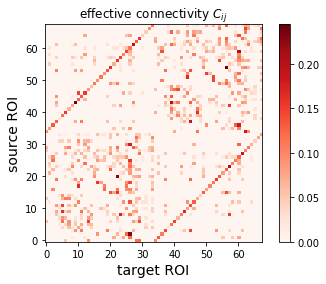

In [7]:
# Plot C-matrix for resting state data.
plt.figure()
plt.imshow(C_mod[:, _I_REST_RUN, :, :].mean(axis=_SUBJECT_AXIS),
           origin='lower', cmap='Reds')
plt.colorbar()
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('effective connectivity $C_{ij}$')
plt.show()

### Local variability
As in the paper, local variability ($\Sigma$) is split up into the part exhibited by the rich club and the one exhibited by the peripheral regions.

In [8]:
## Calculate local variability for rich club and periphery.
# Create a 1D-mask for rich club regions.
mask_rc = np.zeros(n_rois, dtype=bool)
indexes_rich_club = [23, 26, 27, 57, 60, 61]
mask_rc[indexes_rich_club] = True
print('Rich club regions:\n',
      np.concatenate(roi_labels[indexes_rich_club]).tolist())

local_var = Sigma_mod[:, :, :, :].diagonal(axis1=2, axis2=3)
rc_var = local_var[:, :, mask_rc].mean(axis=0) # avarage over subjects
periph_var = local_var[:, :, ~mask_rc].mean(axis=0) # avarage over subjects
mean_rc_var = rc_var.mean(axis=1) # avarage over regions
mean_periph_var = periph_var.mean(axis=1) # avarage over regions
conf_int_rc = np.array(stt.t.interval(
    0.95, rc_var.shape[1]-1, loc=mean_rc_var, 
    scale=stt.sem(rc_var, axis=1))).T
conf_int_periph = np.array(stt.t.interval(
    0.95, periph_var.shape[1]-1, loc=mean_periph_var, 
    scale=stt.sem(periph_var, axis=1))).T
print('Mean of local variability (rich club):\n', str(mean_rc_var))
print('Mean of local variability (periphery):\n', str(mean_periph_var))
print('95% confidence interval (rich club):\n', conf_int_rc)
print('95% confidence interval (periphery):\n', conf_int_periph)

Rich club regions:
 ['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']
Mean of local variability (rich club):
 [0.04162144 0.04172214 0.03924228 0.04484446 0.04086206]
Mean of local variability (periphery):
 [0.1490635  0.1541512  0.14432992 0.15982312 0.15312455]
95% confidence interval (rich club):
 [[0.0218512  0.06139169]
 [0.02771601 0.05572828]
 [0.02039205 0.0580925 ]
 [0.02958672 0.0601022 ]
 [0.02879221 0.05293191]]
95% confidence interval (periphery):
 [[0.12516324 0.17296376]
 [0.12738577 0.18091663]
 [0.12030654 0.1683533 ]
 [0.13333422 0.18631201]
 [0.12636727 0.17988183]]


### Input-output ratio
The information flow between regions is encapsulated in the $C$-matrix. In order to test the hypotheses that the rich club might gate the input it receives from peripheral regions, the inter-rich-club-connections are ignored. This means that only the information flow from and to the rich club is examined when it comes to the inspection of the rich club input-output-ratio.

The input-output ratio of the periphery takes into account all inter-periphery activity (exclusively).

In [9]:
## Calculate the input-to-output ratio of total incoming/outgoing EC.
# Create a 2D-mask for inter rich club connections.
mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
rc_ind_combin = np.array(list(
    itertools.product(indexes_rich_club, repeat=2))).T
mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True
# Calculate the ratio of incoming/outgoing EC from and to the rich club
no_rc_connections_C = np.copy(C_mod)
no_rc_connections_C[:, :, mask_inter_rc] = 0
roi_input = no_rc_connections_C[:, :, :, :].sum(axis=2)
roi_output = no_rc_connections_C[:, :, :, :].sum(axis=3)
io_rc = (roi_input[:, :, mask_rc].mean(axis=0) /
         roi_output[:, :, mask_rc].mean(axis=0))
# Calculate and print the mean io-ratio and the CI for rich club regions
mean_rc_io = io_rc[:, :].mean(axis=1)
conf_int_rc = np.array(stt.t.interval(
    0.95, io_rc.shape[1]-1, loc=mean_rc_io, 
    scale=stt.sem(io_rc, axis=1))).T
print('Mean input-to-output ratio of the rich club:\n', str(mean_rc_io))
print('95% confidence interval (rich club):\n', str(conf_int_rc))

# Create a 2D-mask for inter periphery connections.
mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
periph_ind_combin = np.array(list(itertools.product(list(
    x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
# Calculate the ratio of incoming/outgoing EC among peripheral regions 
only_periph_connections_C = np.copy(C_mod)
only_periph_connections_C[:, :, ~mask_inter_periph] = 0
roi_input = only_periph_connections_C[:, :, :, :].sum(axis=2)
roi_output = only_periph_connections_C[:, :, :, :].sum(axis=3)
io_periph = (roi_input[:, :, ~mask_rc].mean(axis=0) /
         roi_output[:, :, ~mask_rc].mean(axis=0))
# Calculate and print the mean io-ratio and the CI for peripheral regions
mean_periph_io = io_periph[:, :].mean(axis=1)
conf_int_periph = np.array(stt.t.interval(
    0.95, io_periph.shape[1]-1, loc=mean_periph_io, 
    scale=stt.sem(io_periph, axis=1))).T
print('Mean input-to-output ratio of the priphery:\n', str(mean_periph_io))
print('95% confidence interval (priphery):\n', str(conf_int_periph))

# plt.figure()
# plt.imshow(mask_inter_rc, origin='lower')
# plt.xlabel('target ROI', fontsize=14)
# plt.ylabel('source ROI', fontsize=14)
# plt.title('Mask for inter rc connections', fontsize=12)
# plt.show()
# 
# plt.figure()
# plt.imshow(mask_inter_periph, origin='lower')
# plt.xlabel('target ROI', fontsize=14)
# plt.ylabel('source ROI', fontsize=14)
# plt.title('Mask for inter periphery connections', fontsize=12)
# plt.show()

Mean input-to-output ratio of the rich club:
 [1.48495694 1.88671523 1.56186645 1.64396907 1.66005386]
95% confidence interval (rich club):
 [[0.72316304 2.24675083]
 [1.09763718 2.67579327]
 [0.7003348  2.4233981 ]
 [0.81726144 2.4706767 ]
 [0.93711842 2.3829893 ]]
Mean input-to-output ratio of the priphery:
 [0.99285896 1.01499667 1.01237532 1.02449427 1.00399315]
95% confidence interval (priphery):
 [[0.90373501 1.08198291]
 [0.90618691 1.12380642]
 [0.90971716 1.11503347]
 [0.91160185 1.13738669]
 [0.89968467 1.10830163]]


### References
<a id='references'></a>
MOUEC-Estimation notebook by Gilson et al. (2019): Andrea Insabato, Gorka Zamora-López, Matthieu Gilson 1_MOUEC_Estimation.ipynb. 2019. https://github.com/mb-BCA/notebooks_review2019/blob/master/1_MOUEC_Estimation.ipynb

*MOU_Simulation_Estimation* notebook: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson MOU_Simulation_Estimation.ipynb. 2019. https://github.com/mb-BCA/pyMOU/blob/master/examples/MOU_Simulation_Estimation.ipynb

*pyMOU* library: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson. 2019. https://github.com/mb-BCA/pyMOU 

Senden et al. (2017): M. Senden, N. Reuter, M. P. van den Heuvel, R. Goebel, G. Deco, and M. Gilson. Task-related effective connectivity reveals that the cortical rich club gates cortex-wide communication. Hum Brain Mapp, 2017. https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23913